In [1]:
import os
import json
import wandb
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')

from utils.training_dynamic_utils import plot_datamap, get_data_points_from_indices, get_data_subset
from utils.wandb_utils import *
from utils.dataset_utils import get_train_val_test_sets

%load_ext autoreload
%autoreload 2

In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = 'summarise_results.ipynb'
wandb.login()
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [5]:
api = wandb.Api(timeout=60)

## Utils

In [8]:

def transforms_runs_into_dataframe(runs):
	"""
	Returns
	- Dataframe including
		- all configs
		- performance of best model
	"""
	name_list, ids_list, config_list, summary_list = [], [], [], []
	for i, run in enumerate(runs):
		summary_list.append(run.summary._json_dict)

		# .config contains the hyperparameters. We remove special values that start with _.
		config_list.append(
			{k: v for k,v in run.config.items()
			if not k.startswith('_')}
		)

		# .name is the human-readable name of the run.
		name_list.append(run.name)
		ids_list.append(run.id)

	return pd.concat([
			pd.DataFrame({"name": name_list}),
			pd.DataFrame({"id": ids_list}),
			pd.DataFrame(summary_list),
			pd.DataFrame(config_list)
		],
		axis=1
	)

## Analysis

### Teacher models

In [ ]:
runs = api.runs('l46_datamaps/all_datasets_training_teacher_models', {
	'State': 'finished'
})

In [9]:
df = transforms_runs_into_dataframe(runs)

In [13]:
df.head()

,name,id,_wandb,lr-Adam,val_loss,test_loss,parameter_count,val_acc,test_recall,train_acc_epoch,...,metric_model_selection,pretrained_from_github,selector_forgetfulness,patience_early_stopping,track_training_dynamics,force_full_epoch_training,prev_run_name_for_dynamics,knowledge_distillation_loss,knowledge_distillation_loss_alpha,knowledge_distillation_label_smoothing
0,summer-sweep-5,lkxxttrg,{'runtime': 13},NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,val_loss,False,top,3,False,False,run_20231229_095038,KD,0.5,0.1
1,run_20231229_214555,kwpjh1xj,{'runtime': 19},NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,val_loss,False,top,3,False,False,run_20231229_095038,KD,0.5,0.1
2,run_20231229_214446,0peo11x8,{'runtime': 19},NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,val_loss,False,top,3,False,False,run_20231229_095038,KD,0.5,0.1
3,run_20231229_214336,sv6yvr4x,{'runtime': 20},NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,val_loss,False,top,3,False,False,run_20231229_095038,KD,0.5,0.1
4,run_20231229_213903,f9060yln,{'runtime': 166},0.001,1.138232,1.148248,11181642.0,0.5989,0.602889,0.473725,...,val_loss,False,top,3,False,False,run_20231229_095038,KD,0.5,0.1


In [18]:
df_cleaned = df.dropna(subset=['val_acc'])

In [22]:
df_max_val_acc = df.loc[df.groupby('dataset')['val_acc'].idxmax()]


In [23]:
len(df_max_val_acc)

3

In [27]:
df_max_val_acc.columns

Index(['name', 'id', '_wandb', 'lr-Adam', 'val_loss', 'test_loss',
       'parameter_count', 'val_acc', 'test_recall', 'train_acc_epoch',
       '_timestamp', 'test_precision', 'trainer/global_step', '_step', 'epoch',
       'test_f1', 'test_acc', '_runtime', 'model_size_mb', 'train_acc_step',
       'train_loss_step', 'train_loss_epoch', 'seed', 'tags', 'group', 'model',
       'notes', 'epochs', 'dataset', 'job_type', 'num_gpus', 'max_steps',
       'optimizer', 'precision', 'test_only', 'model_size', 'pretrained',
       'save_top_k', 'accelerator', 'p_ambiguous', 'p_confidence',
       'deterministic', 'disable_wandb', 'learning_rate', 'p_correctness',
       'p_easytolearn', 'p_hardtolearn', 'p_variability', 'checkpoint_dir',
       'val_split_seed', 'wandb_log_freq', 'wandb_run_name', 'hard_label_loss',
       'overfit_batches', 'p_forgetfulness', 'subset_argument',
       'wandb_log_model', 'logging_interval', 'train_batch_size',
       'data_augmentation', 'distil_experiment', 

In [31]:
df_max_val_acc[['dataset','model','model_size', 'val_acc', 'test_f1','pretrained', 'learning_rate']]

,dataset,model,model_size,val_acc,test_f1,pretrained,learning_rate
21,cifar10,resnet,large,0.841000,0.829893,True,0.0001
13,cifar100,resnet,large,0.577500,0.573686,True,0.0001
10,mnist,resnet,large,0.990083,0.987615,True,0.0010


In [ ]:
df_max_val_acc

### CIFAR-10

#### Phase 1

In [54]:
runs = api.runs('l46_datamaps/cifar10_knowledge_distillation_subset_training', {
	'State': 'finished'
})
df = transforms_runs_into_dataframe(runs)

In [33]:
df['tags'].value_counts()

[tag3]    234
[tag4]    126
[tag2]    116
Name: tags, dtype: int64

In [90]:
phase1_df = df.copy()
phase1_df['tags'] = phase1_df['tags'].str[0]
phase1_df = phase1_df[phase1_df['tags'] =='tag2']


In [89]:
df.columns

Index(['name', 'id', 'train_loss_step', 'test_acc', 'model_size_mb',
       'parameter_count', 'train_acc_epoch', 'test_precision',
       'train_acc_step', 'trainer/global_step', 'lr-Adam', 'test_f1',
       '_runtime', 'val_loss', 'epoch', '_timestamp', 'test_recall',
       'train_loss_epoch', '_step', '_wandb', 'val_acc', 'test_loss', 'seed',
       'tags', 'group', 'model', 'notes', 'epochs', 'dataset', 'job_type',
       'num_gpus', 'p_random', 'max_steps', 'optimizer', 'precision',
       'test_only', 'model_size', 'pretrained', 'save_top_k', 'accelerator',
       'p_ambiguous', 'p_confidence', 'deterministic', 'disable_wandb',
       'learning_rate', 'p_correctness', 'p_easytolearn', 'p_hardtolearn',
       'p_variability', 'checkpoint_dir', 'val_split_seed', 'wandb_log_freq',
       'wandb_run_name', 'hard_label_loss', 'overfit_batches',
       'p_forgetfulness', 'subset_argument', 'wandb_log_model',
       'logging_interval', 'train_batch_size', 'data_augmentation',
       'd

In [94]:
phase1_df['p_random'].value_counts()

0.33    9
Name: p_random, dtype: int64

In [107]:
def subset_split(row):
    ret = ""
    if row['p_random'] and not pd.isna(row['p_random']):
        ret += f"p_random={row['p_random']}, "
    
    for col in ['p_easytolearn', 'p_hardtolearn', 'p_ambiguous']:
        if row[col] and row[col] != 0.0:
            ret += f"{col}={row[col]}, "
            
    for i in range(4):
        col = ['p_confidence', 'p_correctness', 'p_variability', 'p_forgetfulness'][i]
        selector = [ 'selector_confidence', 'selector_correctness', 'selector_variability', 'selector_forgetfulness'][i]
        if row[col] and row[col] != 0.0:
            ret += f"{col}={row[col]}, "
            ret += f"{selector}={row[selector]}, "
    if len(ret) ==0:
        ret = "full training set"
    return ret
                    
phase1_df['subset_split'] = phase1_df.apply(
    lambda row: subset_split(row), 
    axis=1
)
# 

In [108]:
phase1_df['subset_split'].value_counts()

p_random=0.33,                                           9
p_forgetfulness=0.33, selector_forgetfulness=bottom,     9
p_forgetfulness=0.33, selector_forgetfulness=top,        9
p_correctness=0.33, selector_correctness=bottom,         9
p_correctness=0.33, selector_correctness=top,            9
p_variability=0.33, selector_variability=bottom,         9
p_variability=0.33, selector_variability=top,            9
p_confidence=0.33, selector_confidence=bottom,           9
p_confidence=0.33, selector_confidence=top,              9
p_easytolearn=0.33,                                      9
p_ambiguous=0.33,                                        9
p_hardtolearn=0.33,                                      9
full training set                                        8
Name: subset_split, dtype: int64

In [139]:
phase1_df[phase1_df['subset_split']=='p_random=0.33, '][[
         '_step',
         'val_acc', 
         'model', 
            'val_split_seed', 
         'prev_run_name_for_dynamics', 
         'knowledge_distillation_loss_alpha',
         'knowledge_distillation_label_smoothing',
         'learning_rate'
         ]]


,_step,val_acc,model,val_split_seed,prev_run_name_for_dynamics,knowledge_distillation_loss_alpha,knowledge_distillation_label_smoothing,learning_rate
360,156,0.6028,mobilenet,44,run_20231229_095038,0.5,0.1,0.001
361,156,0.6122,mobilenet,43,run_20231229_095038,0.5,0.1,0.001
362,156,0.6299,mobilenet,42,run_20231229_095038,0.5,0.1,0.001
363,125,0.8246,efficientnet,44,run_20231229_095038,0.5,0.1,0.001
364,125,0.8304,efficientnet,43,run_20231229_095038,0.5,0.1,0.001
365,125,0.8274,efficientnet,42,run_20231229_095038,0.5,0.1,0.001
366,140,0.7634,resnet,44,run_20231229_095038,0.5,0.1,0.001
367,156,0.7713,resnet,43,run_20231229_095038,0.5,0.1,0.001
368,156,0.7765,resnet,42,run_20231229_095038,0.5,0.1,0.001


In [111]:
phase1_df.groupby(['model', 'subset_split'])['val_acc'].mean()
# phase1_df_max_val_acc[['dataset','model','model_size', 'val_acc', 'test_f1','pretrained', 'learning_rate', 'subset_argument', 'p_random','p_easytolearn', 'p_hardtolearn','p_ambiguous','p_variability']]


model         subset_split                                         
efficientnet  full training set                                        0.819133
              p_ambiguous=0.33,                                        0.710867
              p_confidence=0.33, selector_confidence=bottom,           0.727300
              p_confidence=0.33, selector_confidence=top,              0.722700
              p_correctness=0.33, selector_correctness=bottom,         0.772933
              p_correctness=0.33, selector_correctness=top,            0.786833
              p_easytolearn=0.33,                                      0.718967
              p_forgetfulness=0.33, selector_forgetfulness=bottom,     0.728533
              p_forgetfulness=0.33, selector_forgetfulness=top,        0.713467
              p_hardtolearn=0.33,                                      0.742267
              p_random=0.33,                                           0.827467
              p_variability=0.33, selector_variabili

#### Phase 2

In [116]:
phase2_df = df.copy()
phase2_df['tags'] = phase2_df['tags'].str[0]
phase2_df = phase2_df[phase2_df['tags'] =='tag3']


In [117]:
phase2_df['subset_split'] = phase2_df.apply(
    lambda row: subset_split(row), 
    axis=1
)

In [134]:
phase2_df[~phase2_df['subset_split'].isin(['p_random=0.01, ','p_random=0.05, ', 'p_random=0.1, ', 'p_random=0.25, ', 'p_random=0.33, ','p_random=0.55, '])].groupby(['model', 'subset_split'])['val_acc'].mean()


model         subset_split                                                    
efficientnet  p_easytolearn=0.05, p_hardtolearn=0.14, p_ambiguous=0.14,           0.662200
              p_easytolearn=0.05, p_hardtolearn=0.24573, p_ambiguous=0.24573,     0.746000
              p_easytolearn=0.11, p_hardtolearn=0.11, p_ambiguous=0.11,           0.686567
              p_easytolearn=0.11, p_hardtolearn=0.18953, p_ambiguous=0.18953,     0.750733
              p_easytolearn=0.14, p_hardtolearn=0.05, p_ambiguous=0.14,           0.718733
              p_easytolearn=0.14, p_hardtolearn=0.09755, p_ambiguous=0.18755,     0.735433
              p_easytolearn=0.14, p_hardtolearn=0.14, p_ambiguous=0.05,           0.727700
              p_easytolearn=0.14, p_hardtolearn=0.18832, p_ambiguous=0.09832,     0.728400
              p_easytolearn=0.165, p_ambiguous=0.165,                             0.734667
              p_easytolearn=0.165, p_hardtolearn=0.165,                           0.728317
           

In [123]:
phase2_df['subset_split'].value_counts()

p_random=0.55,                                                      18
p_random=0.25,                                                      18
p_random=0.1,                                                       18
p_random=0.05,                                                      18
p_random=0.01,                                                      18
p_easytolearn=0.165, p_hardtolearn=0.165,                           18
p_easytolearn=0.165, p_ambiguous=0.165,                             18
p_random=0.33,                                                      18
p_hardtolearn=0.165, p_ambiguous=0.165,                              9
p_easytolearn=0.14, p_hardtolearn=0.05, p_ambiguous=0.14,            9
p_easytolearn=0.14, p_hardtolearn=0.14, p_ambiguous=0.05,            9
p_easytolearn=0.05, p_hardtolearn=0.14, p_ambiguous=0.14,            9
p_easytolearn=0.05, p_hardtolearn=0.24573, p_ambiguous=0.24573,      9
p_easytolearn=0.11, p_hardtolearn=0.18953, p_ambiguous=0.18953,      9
p_easy

In [140]:
phase2_df[phase2_df['subset_split']=="p_random=0.33, "][[
        # 'name', 'id', 'train_loss_step', 'test_acc', 'model_size_mb',
    #    'parameter_count', 'train_acc_epoch', 'test_precision',
    #    'train_acc_step', 'trainer/global_step', 'lr-Adam', 'test_f1',
    #    '_runtime', 'val_loss', 'epoch', '_timestamp', 'test_recall',
    #    'train_loss_epoch', 
    '_step',
   #  '_wandb', 
    'val_acc', 
   #  'test_loss', 
      #  'seed',
    #    'tags', 'group', 
       'model', 
    #    'notes', 
      # 'epochs', 
   #  'dataset', 'job_type',
    #    'num_gpus', 'p_random', 'max_steps', 
    #    'optimizer', 
    #    'precision',
    #    'test_only', 
   #  'model_size', 
    #    'pretrained', 'save_top_k', 
    #    'accelerator',
    #    'p_ambiguous', 'p_confidence', 
    #    'deterministic', 
    #    'disable_wandb',
    #    'learning_rate', 
    #    'p_correctness', 'p_easytolearn', 'p_hardtolearn',
    #    'p_variability', 'checkpoint_dir', 
       'val_split_seed', 
    #    'wandb_log_freq',
    #    'wandb_run_name', 'hard_label_loss', 'overfit_batches',
    #    'p_forgetfulness', 'subset_argument', 'wandb_log_model',
    #    'logging_interval', 'train_batch_size', 'data_augmentation',
      #  'distil_experiment', 
   #  'distillation_temp', 'gradient_clip_val',
    #    'teacher_model_run', 'selection_from_low', 'train_on_full_data',
    #    'val_check_interval', 'wandb_project_name', 'selector_confidence',
    #    'selector_correctness', 'selector_variability', 'suffix_wand_run_name',
    #    'training_dynamics_dir', 'validation_batch_size',
    #    'metric_model_selection', 'pretrained_from_github',
    #    'selector_forgetfulness', 
   #  'patience_early_stopping',
    #    'track_training_dynamics', 'force_full_epoch_training',
       'prev_run_name_for_dynamics', 
    #    'knowledge_distillation_loss',
       'knowledge_distillation_loss_alpha',
       'knowledge_distillation_label_smoothing',
         'learning_rate'
         ]]

,_step,val_acc,model,val_split_seed,prev_run_name_for_dynamics,knowledge_distillation_loss_alpha,knowledge_distillation_label_smoothing,learning_rate
131,72,0.4716,mobilenet,44,run_20231229_095038,0.5,0.1,0.001
133,72,0.4536,mobilenet,43,run_20231229_095038,0.5,0.1,0.001
134,72,0.4695,mobilenet,44,run_20231229_095038,0.5,0.1,0.001
135,72,0.4762,mobilenet,42,run_20231229_095038,0.5,0.1,0.001
137,72,0.4587,mobilenet,43,run_20231229_095038,0.5,0.1,0.001
139,72,0.4855,mobilenet,42,run_20231229_095038,0.5,0.1,0.001
167,72,0.7929,efficientnet,44,run_20231229_095038,0.5,0.1,0.001
169,65,0.7837,efficientnet,43,run_20231229_095038,0.5,0.1,0.001
170,72,0.7899,efficientnet,44,run_20231229_095038,0.5,0.1,0.001
171,72,0.7962,efficientnet,42,run_20231229_095038,0.5,0.1,0.001


#### Phase 3

In [142]:
phase2_df[phase2_df['subset_split'].isin(['p_random=0.01, ','p_random=0.05, ', 'p_random=0.1, ', 'p_random=0.25, ', 'p_random=0.33, ','p_random=0.55, '])].groupby(['model', 'subset_split'])['val_acc'].mean()


model         subset_split   
efficientnet  p_random=0.01,     0.423433
              p_random=0.05,     0.595333
              p_random=0.1,      0.706683
              p_random=0.25,     0.769783
              p_random=0.33,     0.790833
              p_random=0.55,     0.804733
mobilenet     p_random=0.01,     0.100017
              p_random=0.05,     0.202000
              p_random=0.1,      0.337417
              p_random=0.25,     0.438033
              p_random=0.33,     0.469183
              p_random=0.55,     0.544117
resnet        p_random=0.01,     0.515250
              p_random=0.05,     0.603650
              p_random=0.1,      0.603283
              p_random=0.25,     0.646850
              p_random=0.33,     0.681117
              p_random=0.55,     0.730817
Name: val_acc, dtype: float64

In [144]:
# Raw data
data = {
    "model": ["efficientnet"] * 6 + ["mobilenet"] * 6 + ["resnet"] * 6,
    "p_random": [0.01, 0.05, 0.1, 0.25, 0.33, 0.55] * 3,
    "value": [
        0.423433, 0.595333, 0.706683, 0.769783, 0.790833, 0.804733,
        0.100017, 0.202000, 0.337417, 0.438033, 0.469183, 0.544117,
        0.515250, 0.603650, 0.603283, 0.646850, 0.681117, 0.730817
    ]
}
phase3_df = pd.DataFrame(data)
phase3_df

,model,p_random,value
0,efficientnet,0.01,0.423433
1,efficientnet,0.05,0.595333
2,efficientnet,0.10,0.706683
3,efficientnet,0.25,0.769783
4,efficientnet,0.33,0.790833
5,efficientnet,0.55,0.804733
6,mobilenet,0.01,0.100017
7,mobilenet,0.05,0.202000
8,mobilenet,0.10,0.337417
9,mobilenet,0.25,0.438033


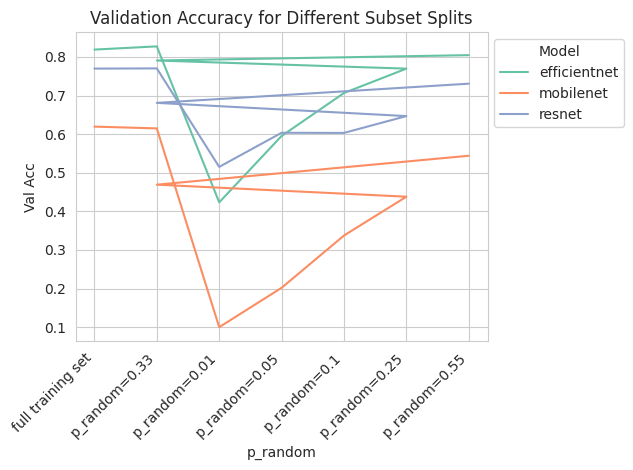

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Model': ['efficientnet', 'efficientnet', 'efficientnet', 'efficientnet', 'efficientnet', 'efficientnet', 'efficientnet', 'efficientnet',
              'mobilenet', 'mobilenet', 'mobilenet', 'mobilenet', 'mobilenet', 'mobilenet', 'mobilenet', 'mobilenet',
              'resnet', 'resnet', 'resnet', 'resnet', 'resnet', 'resnet', 'resnet', 'resnet'],
    'Subset Split': ['full training set', 'p_random=0.33', 'p_random=0.01', 'p_random=0.05', 'p_random=0.1', 'p_random=0.25', 'p_random=0.33', 'p_random=0.55',
                      'full training set', 'p_random=0.33', 'p_random=0.01', 'p_random=0.05', 'p_random=0.1', 'p_random=0.25', 'p_random=0.33', 'p_random=0.55',
                      'full training set', 'p_random=0.33', 'p_random=0.01', 'p_random=0.05', 'p_random=0.1', 'p_random=0.25', 'p_random=0.33', 'p_random=0.55'],
    'Val Acc': [0.819133, 0.827467, 0.423433, 0.595333, 0.706683, 0.769783, 0.790833, 0.804733,
                0.619600, 0.614967, 0.100017, 0.202000, 0.337417, 0.438033, 0.469183, 0.544117,
                0.769900, 0.770400, 0.515250, 0.603650, 0.603283, 0.646850, 0.681117, 0.730817]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Filter the data for each model and create a line plot for Val Acc
for model in df['Model'].unique():
    model_data = df[df['Model'] == model]
    plt.plot(model_data['Subset Split'], model_data['Val Acc'], label=model)

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('p_random')
plt.ylabel('Val Acc')
plt.title('Validation Accuracy for Different Subset Splits')
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()
